# Develop observability status

With this notebook I a aiming to optimize the observabilty status determination with a simpler approach that is more reliable and more cost efficient, i.e. reducing run time.

In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
from astropy.time import Time
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from db import TelescopeManager
from surveyplanner import SurveyPlanner, Telescope
from visualizations import ObservabilityVisualizer

## The ideas

I realised that my approach of [fitting the slope of observability durations](Develop_ObservabilityStatusUpdate.ipynb) is way too complicated. Much simpler: 
- A field observable until the end of the night is rising. 
- A field observable in the beginning of the night is setting. 
- A field rising and setting during the night is plateauing. 

This way I also do not need observability windows of pre- and succeeding nights to determine a night's observabilty status. I can determine the status based on a nights observability window.

However, I need to change the way that the constraints are applied. E.g. the Moon distance constraint can mess this up. 

It would be useful to classify constraints as two types:
- *hard* constraints, e.g. hourangle limit, elevation limit, etc, and
- *variable* constraints, e.g. Moon distance.

Both types will first be applied separately. The hard constraints are then used to determine the observability status. After that hard and variable constraints are combined to determine the actual observability window. The joint constraints may then change the status to "not observable".

## Test the new idea

Ignoring the effects that variable constraints may have, lets apply the simple status classification defined above and check how it works compared to the previous approach.

Load relevant classes:

In [101]:
db_name = 'test_planner.sqlite3'
planner = SurveyPlanner(db_name)
manager = TelescopeManager(db_name)
visualizer = ObservabilityVisualizer(surveyplanner=planner)

### Select telescope and date

In [132]:
telescope_name = 'Skinakas'
night = '2024-05-23'

Get sun set and rise time:

In [133]:
night = Time(night)
telescope_params = manager.get_telescopes(name=telescope_name, constraints=True)[0]
telescope = Telescope(
        telescope_params['lat'], telescope_params['lon'], telescope_params['height'], 
        telescope_params['utc_offset'], name=telescope_name)
date = night.to_datetime()
sun_set, sun_rise = telescope.get_sun_set_rise(
        date.year, date.month, date.day, telescope_params['constraints']['Twilight']['twilight'])
print('Sun set: ', sun_set)
print('Sun rise:', sun_rise)

Telescope Skinakas created.
Sun set:  2024-05-23T18:27:56.215
Sun rise: 2024-05-24T02:06:17.864


Get observable fields:

In [134]:
fields = planner.query_fields(observable_night=night, telescope=telescope_name)
fields = pd.DataFrame(fields)
fields.head(3)

,field_id,fov,center_ra,center_dec,tilt,telescope,active,jd_first,jd_next,nobs_tot,nobs_done,nobs_pending,date_start,date_stop,duration,status,setting_duration
0,57,0.087266,6.071393,0.043633,0.0,Skinakas,1,2460310.5,2460690.5,1,0,1,2024-05-24 01:47:00.000,2024-05-24 02:06:17.864,0.013401,rising,NaN
1,29,0.087266,3.035696,0.043633,0.0,Skinakas,1,2460310.5,2460690.5,1,0,1,2024-05-23 18:27:56.215,2024-05-23 21:26:00.000,0.123655,setting,37.042344
2,113,0.087266,5.859600,0.087266,0.0,Skinakas,1,2460310.5,2460690.5,1,0,1,2024-05-24 00:50:00.000,2024-05-24 02:06:17.864,0.052985,rising,NaN


### Determine status according to new criteria

In [135]:
# determine status:
setting = np.isclose(Time(fields['date_start'].to_list(), format='iso').mjd, sun_set.mjd, rtol=1e-12)
rising = np.isclose(Time(fields['date_stop'].to_list(), format='iso').mjd, sun_rise.mjd, rtol=1e-12)
plateauing = ~np.logical_xor(setting, rising)

# add new status to dataframe:
status_new = fields.loc[:, 'status'].copy()
status_new.loc[setting] = 'setting'
status_new.loc[rising] = 'rising'
status_new.loc[plateauing] = 'plateauing'
fields.insert(16, 'status_new', status_new)

# print results:
print(f'Fields rising:      {rising.sum():5d}')
print(f'Fields plateauing:  {plateauing.sum():5d}')
print(f'Fields setting:     {setting.sum():5d}')
print('Correct sum:        ', setting.sum() + rising.sum() + plateauing.sum() == fields.shape[0])

Fields rising:        319
Fields plateauing:    153
Fields setting:       753
Correct sum:         False


### Where do the results differ?

In [136]:
i_differ = np.nonzero((fields['status'] != fields['status_new']).values)[0]
print('Results differ:', i_differ.shape[0])

fields.loc[i_differ, ('status', 'status_new')]

Results differ: 35


,status,status_new
151,setting,plateauing
241,setting,plateauing
284,setting,plateauing
292,setting,plateauing
327,plateauing,rising
354,setting,plateauing
368,setting,plateauing
372,setting,plateauing
373,setting,plateauing
437,setting,plateauing


### Visualize comparison

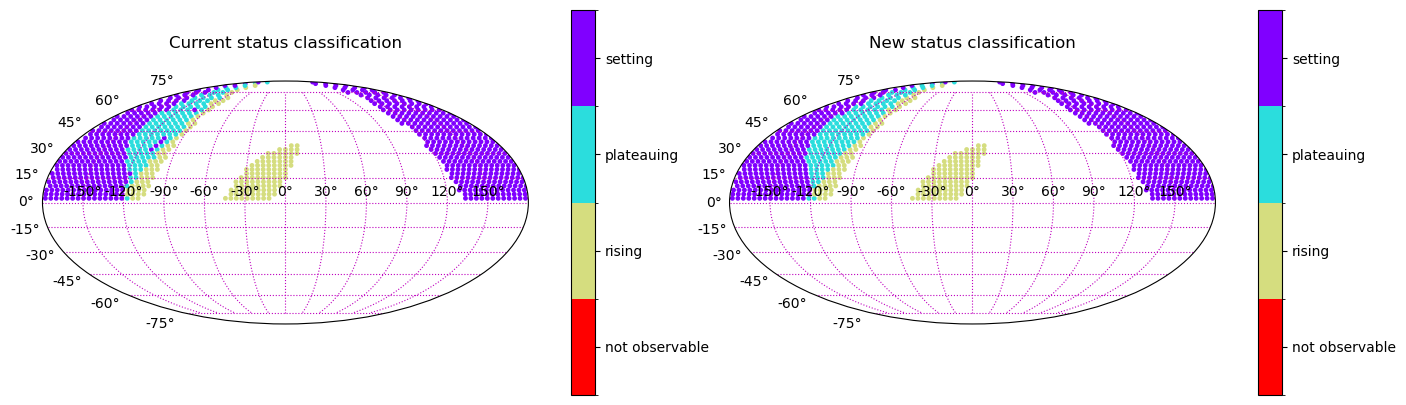

In [137]:
fig = plt.figure(figsize=(16, 5))
gs = GridSpec(1, 5, width_ratios=[20, 1, 2, 20, 1])
ax = [plt.subplot(gs[0], projection='mollweide'),
      plt.subplot(gs[3], projection='mollweide')]
cax = [plt.subplot(gs[1]),
      plt.subplot(gs[4])]

visualizer.set_fields(fields.to_dict('records'))
visualizer.plot('status', projection='mollweide', ax=ax[0], cax=cax[0], plot_kws={'s': 6})
ax[0].set_title('Current status classification', y=1.1)

visualizer.set_fields(fields.drop('status', axis=1).rename(columns={'status_new': 'status'}).to_dict('records'))
visualizer.plot('status', projection='mollweide', ax=ax[1], cax=cax[1], plot_kws={'s': 6})
ax[1].set_title('New status classification', y=1.1);

## Results

The new method works much better. With the exceptions where the close vicinity to the Moon messes up the classification, which is expected.